# Feature Selection / Model

## Import Necessary Libraries

In [58]:
import numpy as np  # Numerical computing library
import seaborn as sns  # Data visualization library based on Matplotlib
import matplotlib.pyplot as plt  # Plotting library
import pandas as pd  # Data analysis and manipulation library

# Ensure Pandas displays all columns in the output
pd.set_option('display.max_columns', None)

# Import machine learning tools from scikit-learn
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets
# from sklearn.preprocessing import RobustScaler  # Scales features using robust statistics to handle outliers
from sklearn.preprocessing import StandardScaler # Scales features using standard statistics

# Import statistical modeling tools from statsmodels
import statsmodels.api as sm  # Provides classes for estimating different statistical models
import statsmodels.tools  # Utility functions for statistical modeling

df = pd.read_csv('/Users/mahamedabdulle/Documents/digital futures/projects/who/Life Expectancy Data.csv')

## Feature Engineering

### Quick Summary of What's Ahead
Based on our Exploratory Data Analysis (EDA), we will identify key features that influence life expectancy and enhance the dataset by generating new features—a process known as **Feature Enrichment**.  

We will create two versions of the model, allowing users to choose between:  

- **A safer, privacy-conscious model** – This version uses only non-sensitive data, resulting in a simpler model with reduced predictive performance.  
- **A more robust model** – This version collects additional details through a series of questions, improving accuracy but requiring more sensitive input.  

This approach ensures flexibility, balancing privacy concerns with predictive performance.

We performed feature engineering after splitting the data to prevent leakage and ensure our model generalises effectively to unseen data.

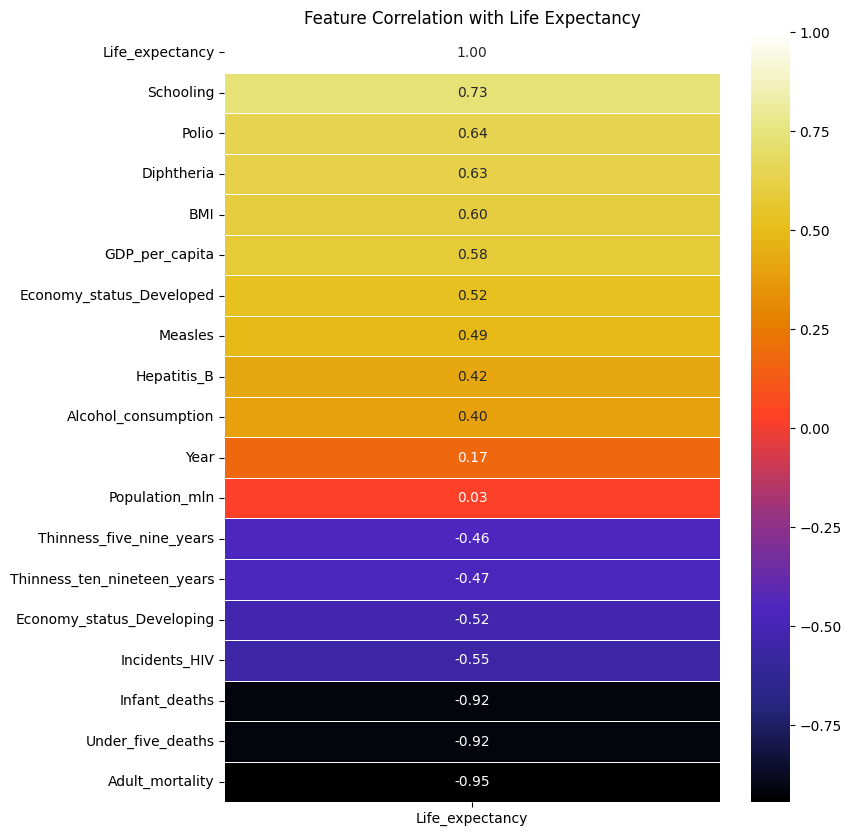

In [60]:
# Compute correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Extract correlation values with target variable 'Life_expectancy'
target_corr = correlation_matrix[['Life_expectancy']].sort_values(by='Life_expectancy', ascending=False)

# Plot heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(target_corr, cmap="CMRmap", annot=True, fmt=".2f", linewidths=0.5)

# Title and display
plt.title("Feature Correlation with Life Expectancy")
plt.show()

[Reference](https://saturncloud.io/blog/how-to-calculate-pandas-correlation-of-one-column-against-all-others/)  
We can see the correlation matrix above, to help decide which features play a big part in prediciting `life_expectancy`, to help our model work more accurately.

## Safe Feature Engineering / Model

The **safe model** will remove any type of sensitive data, such as removing `Infant_deaths`  as that is quite a sensitive topic to address.  

### Feature Engineering Safe

In [61]:
def safe_feature_engineering(df):
    df = df.copy()
    df = df[['Adult_mortality', 'Schooling', 'BMI', 'GDP_per_capita']]
    # Standardize features
    scaler = StandardScaler()
    df['gdp_log'] = np.log(df['GDP_per_capita'])
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

    # Add constant for regression
    df_scaled = sm.add_constant(df_scaled)

    return df_scaled

#### Explaining Features:
We decided not to use any sensitive information, such as `Infant_deaths`, as that can be very distressing.  
We decided to add `Schooling` because it is not a distressing or sensitive feature and it has a very high positive correlation with `life_expectancy`.  
We decided to add `BMI` because it is not a sensitive data.  
We decided to add `GDP_per_capita` because it has a high positive correlation with `life_expectancy`.  
`gdp_log` is a feature we used by *feature enrinching*. The data for `GPD_per_capita` was expononetial with our target `life_expectancy`, so by using the log function, we can observe it better

### Safe Model

In [62]:
def safe_model(df):
    # Columns to drop
    who_model_data = df.drop(['Year'],axis=1)
    
    #Create features variable
    features = list(who_model_data.columns)
    features.remove('Life_expectancy') # What we are trying to predict!
    
    # Create Features and Target Variables
    X = who_model_data[features]
    y = who_model_data['Life_expectancy']
    
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, # Features
                                                        y, # Target
                                                        test_size=0.2, # % of total data for test set
                                                        random_state=1401) # Shuffle the data
    
    X_train_fe = safe_feature_engineering(X_train)
    feature_columns = X_train_fe.columns
    
    # Create the Linear Regression Model with the data
    # Dependent variable first, Independent variable second
    lin_reg = sm.OLS(y_train, X_train_fe[feature_columns])
    
    # Fit the LinReg model
    output = lin_reg.fit()
    
    
    # Using the model to predict on the training set
    y_pred = output.predict(X_train_fe[feature_columns])
    
    # Calculate the RMSE of the training data
    rmse_train = statsmodels.tools.eval_measures.rmse(y_train, y_pred)
    
    # Use the model to predit on the testing set, to verify results
    # First apply the feature engineering to the testing set
    X_test_fe = safe_feature_engineering(X_test)
    X_test_fe = X_test_fe[feature_columns]
    
    # Predict the results on the testing data
    y_test_pred = output.predict(X_test_fe)

    # Calculate test RMSE
    rmse_test = statsmodels.tools.eval_measures.rmse(y_test, y_test_pred)

    print(f"Training data RMSE: {rmse_train:.2f}")
    print(f"Testing data RMSE: {rmse_test:.2f}")


    return output.summary()
    
    

In [63]:
safe_model_results = safe_model(df)
safe_model_results

Training data RMSE: 2.05
Testing data RMSE: 1.97


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     9172.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:53:37   Log-Likelihood:                -4890.0
No. Observations:                2291   AIC:                             9792.
Df Residuals:                    2285   BIC:                             9826.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              68.8120      0.043   1608.290      0.000      68.728      68.896
Adult_mortality    -6.8931      0.060   -115.815      0.000      -7.010      -6.776
Schooling           1.8400      0.071     25.769      0.000       1.700       1.980
BMI                -0.2291      0.062     -3.720      0.000      -0.350      -0.108
GDP_per_capita     -0.7178      0.080     -9.024      0.000      -0.874      -0.562
gdp_log             2.0522      0.112     18.361      0.000       1.833       2.271
==============================================================================
Omnibus:                      184.613   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              415.332
Skew:                          -0.498   Prob(JB):                     6.48e-91
Kurtosis:                       4.832   Cond. No.                         5.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explaining Results
RMSE:
The training RMSE is **2.05**, and the testing RMSE is **1.97**. This means that on average, our model’s life expectancy predictions are off by about 1.97 years. Considering our model’s simplicity—and given that the semi-robust benchmark model has an RMSE of 2—this performance is quite good.

**$R^2$** Score:
With an **$R^2$** of **0.953**, the model explains approximately 95% of the variance in the data, indicating a strong overall fit.

AIC and BIC:
The AIC and BIC values are **9792** and **9826**, respectively. Although these scores are high, it’s acceptable in this context since the model was built using a limited number of features to achieve reasonable results rather than to optimize these criteria.

Conditional Number:
We get an extremely low conditional number, with a score of **5.81**, which tells us that our features has low multicolinearity

## Unsafe Feature Engineering / Model

The **unsafe model** will be a lot more robust than the **safe model**, can ask for more sensitive data.

### Feature Engineering Unsafe

In [64]:
def unsafe_feature_engineering(df):
    df = df.copy()
    df = df[['Under_five_deaths', 'Adult_mortality', 'Schooling', 'BMI', 'GDP_per_capita', 'Incidents_HIV','Region']]
    df = pd.get_dummies(df, columns = ['Region'], drop_first = True, prefix = 'region', dtype=int)
    # Standardize features
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    
    # Add constant for regression
    df_scaled = sm.add_constant(df_scaled)
    
    return df_scaled

#### Explaining Features
We decided to use `Under_five_deaths` (**-0.92**) and `Adult_mortality` (**-0.95**) as they have a strong negative correlation with Life Expectancy, indicating that higher mortality rates significantly reduce life expectancy.  

`Schooling` also has a positive correlation (**0.73**) with Life Expectancy, showing that education plays a crucial role in improving health and longevity.  

`BMI` also contributes to Life Expectancy, as maintaining a healthy body mass index is often associated with better overall health and reduced risk of chronic diseases.  

`GDP_per_capita` is another influential factor, with a correlation of **0.58**, highlighting the role of economic prosperity in improving healthcare access and quality of life.  

`Incidents_HIV` has a negative correlation (**-0.55**) with Life Expectancy, suggesting that higher HIV prevalence reduces life expectancy due to its impact on overall health. 

`gdp_log` is a feature we used by *feature enrinching*. The data for `GPD_per_capita` was expononetial with our target `life_expectancy`, so by using the log function, we can observe it better

Additionally, we mapped regions, as geographical location and regional factors also influence Life Expectancy, affecting healthcare access, economic conditions, and lifestyle choices.  

We also scaled the values, to help remove multicolineraity.

### Unsafe Model

In [65]:
def unsafe_model(df):

    # Columns to drop
    who_model_data = df.drop(['Country','Economy_status_Developed', 'Year'], axis=1)
    # Create features variable
    features = list(who_model_data.columns)
    features.remove('Life_expectancy')

    # Create Features and Target Variables
    X = who_model_data[features]
    y = who_model_data['Life_expectancy']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, # Features
                                                        y, # Target
                                                        test_size=0.2, # % of total data for test set
                                                        random_state=1401) # Shuffle the data

    # Apply feature encoding function, if necessary
    X_train_fe = unsafe_feature_engineering(X_train)

    #Assign training feature columns to variable
    feature_columns = X_train_fe.columns

    # Create the Linear Regression Model with the data
    # Dependent variable first, Independent variable second
    lin_reg = sm.OLS(y_train, X_train_fe[feature_columns])

    # Fit the LinReg model
    output = lin_reg.fit()

    output.summary()

    # Using the model to predict on the training set
    y_pred = output.predict(X_train_fe[feature_columns])

    # Calculate the RMSE of the training data
    rmse_train = statsmodels.tools.eval_measures.rmse(y_train, y_pred)

    # Use the model to predit on the testing set, to verify results
    # First apply the feature engineering to the testing set
    X_test_fe = unsafe_feature_engineering(X_test)
    X_test_fe = X_test_fe[feature_columns]

    # Predict the results on the testing data
    y_test_pred = output.predict(X_test_fe)

    # Calculate test RMSE
    rmse_test = statsmodels.tools.eval_measures.rmse(y_test, y_test_pred)

    print(f"Training data RMSE: {rmse_train:.2f}")
    print(f"Testing data RMSE: {rmse_test:.2f}")
    
    return output.summary()

In [66]:
unsafe_model = unsafe_model(df)
unsafe_model

Training data RMSE: 1.30
Testing data RMSE: 1.25


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Life_expectancy   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     8346.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:53:39   Log-Likelihood:                -3847.8
No. Observations:                2291   AIC:                             7726.
Df Residuals:                    2276   BIC:                             7812.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   68.8120      0.027   2529.701      0.000      68.759      68.865
Under_five_deaths                       -3.4708      0.068    -50.950      0.000      -3.604      -3.337
Adult_mortality                         -5.5731      0.075    -74.183      0.000      -5.720      -5.426
Schooling                                0.6577      0.058     11.389      0.000       0.544       0.771
BMI                                     -0.4457      0.050     -8.990      0.000      -0.543      -0.348
GDP_per_capita                           0.6336      0.039     16.310      0.000       0.557       0.710
Incidents_HIV                            0.2845      0.046      6.141      0.000       0.194       0.375
region_Asia                             -0.0223      0.040     -0.554      0.580      -0.101       0.057
region_Central America and Caribbean     0.4911      0.038     12.921      0.000       0.417       0.566
region_European Union                    0.4129      0.049      8.470      0.000       0.317       0.508
region_Middle East                       0.0136      0.038      0.355      0.723      -0.062       0.089
region_North America                     0.1916      0.031      6.129      0.000       0.130       0.253
region_Oceania                          -0.1551      0.036     -4.354      0.000      -0.225      -0.085
region_Rest of Europe                    0.1163      0.040      2.897      0.004       0.038       0.195
region_South America                     0.3563      0.035     10.218      0.000       0.288       0.425
==============================================================================
Omnibus:                       31.126   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.796
Skew:                           0.217   Prob(JB):                     1.02e-08
Kurtosis:                       3.445   Cond. No.                         7.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explaining Results
- **RMSE (Root Mean Squared Error)**:  
  The training RMSE is **1.30**, and the testing RMSE is **1.25**. This means our model’s life expectancy predictions have an average error of about 1.25 years, which indicates a strong performance with minimal prediction error.

- **R² (Coefficient of Determination)**:  
  An **R²** value of **0.981** shows that our model explains roughly **98%** of the variance in the data, reflecting an excellent overall fit.

- **AIC and BIC (Model Selection Criteria)**:  
  The AIC and BIC scores are **7726** and **7812** respectively. These low values suggest that the model strikes a good balance between complexity and goodness-of-fit.

- **P-values**:  
  Most predictors have p-values of zero, indicating strong statistical significance. However, the features `region_Asia` and `region_Middle_East` have p-values of **0.58** and **0.723**, respectively, which suggests that these features might not be statistically significant in the model.

- **Conditional Number**:  
  A low Conditional Number of **7.33** indicates minimal multicollinearity among the features, meaning the predictors are not highly correlated and the model estimates are stable.